In [1]:
from keras.utils import get_file
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re
import matplotlib.pyplot as plt

In [2]:
data_path = "../data/"

TRAIN_FILE = data_path + "qa1_single-supporting-fact_train.txt"
TEST_FILE = data_path + "qa1_single-supporting-fact_test.txt"

In [3]:
def read_data(dir):
    story_temp = []
    questions, answers, stories = [], [], []
    lines = open(dir, 'rb')
    
    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        
        idx, text = line.split(' ', 1)
        
        if(int(idx)) == 1: # when new story comes
            story_temp = []
            
        if '\t' in text: # when 'Q\tA' comes
            question, answer, _ = text.split('\t')
            stories.append([x for x in story_temp if x])
            questions.append(question)
            answers.append(answer)
            
        else: # when story comes
            story_temp.append(text)
            
    lines.close()
    return stories, questions, answers

In [4]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

print(len(train_stories), len(train_questions), len(train_answers))
print(len(test_stories), len(test_questions), len(test_answers))

print(train_stories[3456], train_questions[3456], train_answers[3456])

10000 10000 10000
1000 1000 1000
['John travelled to the garden.', 'John journeyed to the office.', 'Daniel travelled to the kitchen.', 'Daniel moved to the bathroom.'] Where is Daniel?  bathroom


# Tokenizing

In [5]:
def tokenize(sent):
    return [x.strip() for x in re.split('(\W+)', sent) if x.strip()] 

def preprocess(train, test):
    counter = FreqDist() # frequency distribution
    flatten = lambda data: reduce(lambda x, y: x + y, data) # concatenate sentences
    
    story_len, question_len = [], []
    
    for stories, questions, answers in [train, test]:
        for story in stories:
            stories_tokenized = tokenize(flatten(story))
            story_len.append(len(stories_tokenized))
            for word in stories_tokenized:
                counter[word.lower()] += 1
        for question in questions:
            question_tokenized = tokenize(question)
            question_len.append(len(question_tokenized))
            for word in question_tokenized:
                counter[word.lower()] += 1
        for answer in answers:
            answer_tokenized = tokenize(answer)
            for word in answer_tokenized:
                counter[word.lower()] += 1

    # 단어 집합 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [6]:
word2idx, idx2word, story_max_len, question_max_len = preprocess(train_data, test_data)
vocab_size = len(word2idx) + 1

print(word2idx)
print(story_max_len, question_max_len)

{'to': 1, 'the': 2, '.': 3, 'went': 4, 'sandra': 5, 'john': 6, 'daniel': 7, 'mary': 8, 'travelled': 9, 'journeyed': 10, 'back': 11, 'bathroom': 12, 'garden': 13, 'hallway': 14, 'moved': 15, 'office': 16, 'kitchen': 17, 'bedroom': 18, 'where': 19, 'is': 20, '?': 21}
68 4


In [7]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    
    stories, questions, answers = data
    
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w.lower()] for w in tokenize(flatten(story))]
        xq = [word2idx[w.lower()] for w in tokenize(question)]
        
        y = np.zeros(len(word2idx) + 1)
        y[word2idx[answer]] = 1
        
        Xs.append(xs)
        Xq.append(xq)
        Y.append(y)
        
    return pad_sequences(Xs, maxlen=story_maxlen), pad_sequences(Xq, maxlen=question_maxlen), np.array(Y)

In [8]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

print(Xstrain.shape, Xqtrain.shape, Ytrain.shape)
print(Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 68) (10000, 4) (10000, 22)
(1000, 68) (1000, 4) (1000, 22)


# Modeling

In [9]:
from keras.models import Sequential, Model
from keras.layers import Embedding
from keras.layers import Permute, dot, add, concatenate
from keras.layers import LSTM, Dense, Dropout, Input, Activation

In [10]:
# hyperparameters
train_epochs = 120
batch_size = 32
embed_size = 50
lstm_size = 64
dropout_rate = 0.30

input_sequence = Input((story_max_len,))
question = Input((question_max_len,))

# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embedding_dim) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원

# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embedding_dim) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [11]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m KerasTensor(type_spec=TensorSpec(shape=(None, 68, 50), dtype=tf.float32, name=None), name='sequential/dropout/Identity:0', description="created by layer 'sequential'")
Input encoded c KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='sequential_1/dropout_1/Identity:0', description="created by layer 'sequential_1'")
Question encoded KerasTensor(type_spec=TensorSpec(shape=(None, 4, 50), dtype=tf.float32, name=None), name='sequential_2/dropout_2/Identity:0', description="created by layer 'sequential_2'")


In [12]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_maxlen, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

response = add([match, input_encoded_c])  # (samples, story_max_len, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_max_len)
print('Response shape', response)

# 질문 벡터와 답변 벡터를 연결
answer = concatenate([response, question_encoded])
print('Answer shape', answer)

answer = LSTM(lstm_size)(answer)
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)
answer = Activation('softmax')(answer)


Match shape KerasTensor(type_spec=TensorSpec(shape=(None, 68, 4), dtype=tf.float32, name=None), name='activation/Softmax:0', description="created by layer 'activation'")
Response shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 68), dtype=tf.float32, name=None), name='permute/transpose:0', description="created by layer 'permute'")
Answer shape KerasTensor(type_spec=TensorSpec(shape=(None, 4, 118), dtype=tf.float32, name=None), name='concatenate/concat:0', description="created by layer 'concatenate'")


In [13]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

print(model.summary())

history = model.fit([Xstrain, Xqtrain],
                    Ytrain, batch_size, train_epochs,
                    validation_data=([Xstest, Xqtest], Ytest))

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 68)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 4)]                  0         []                            
                                                                                                  
 sequential (Sequential)     (None, None, 50)             1100      ['input_1[0][0]']             
                                                                                                  
 sequential_2 (Sequential)   (None, 4, 50)                1100      ['input_2[0][0]']             
                                                                                              

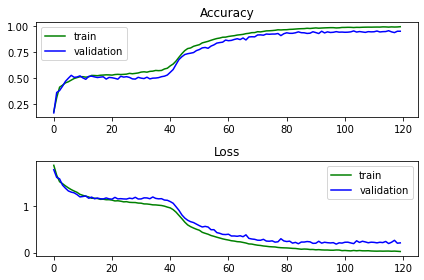

32/32 [==============================] - 0s 1ms/step


In [14]:
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

ytest = np.argmax(Ytest, axis=1)

Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)
